<div class="alert alert-block alert-info">  
<h1><strong>🎨Getting started with GANs</strong></h1>
    <i>“All you need to paint is a few tools, a little instruction, and a vision in your mind.” -Bob Ross😁</i>
</div>

<div class="alert alert-block alert-warning">  
<h1><strong>So what are GANs?</strong></h1>
    <p> GANs or Generative Adversial Networks comprise atleast two neural networks that are trained simultaneously, namely the <b>generator</b> and the <b>discriminator</b>. <br><br>
        The generator learns how to create new images over time that resemble real images and tries to confuse the discriminator whose sole aim is to differentiate between which image is really real and which one is fake/generated.
    </p>
</div>


![](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

![](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

<div class="alert alert-block alert-warning">  
<h1><strong>Moving forward to CycleGAN</strong></h1>
    <p>CycleGAN uses a <b>cycle consistency loss</b> to enable training <b>without the need for paired data</b>. It can translate from one domain to the other without the need of a one-to-one mapping between the source and target domain. All we requre is a directory of source and target images. <br><br>
      Use cases:  
<ul>
    <li>photo-enhancement</li>
    <li>image colorization</li>
    <li>style transfer</li>
</ul>
 <a href="https://www.tensorflow.org/tutorials/generative/cyclegan">Reference</a>
    </p>
</div>

<h3>
A sneak peak into the data we're working with
</h3>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

<h3> Imports <h3>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import cv2

from colorama import Fore, Back, Style
from tensorflow import keras
from tensorflow.keras import layers

y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Number of replicas: 1
2.3.0


In [3]:
monet_jpg_directory = '../input/gan-getting-started/monet_jpg/'
photo_jpg_directory = '../input/gan-getting-started/photo_jpg/'

<h3> Getting image paths from the directory </h3>

In [4]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [5]:
monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)

<h3> Number of images in each directory </h3>

In [6]:
print(f"{y_}Number of Monet images: {g_} {len(monet_images_path)}\n")
print(f"{y_}Number of Photo images: {g_} {len(photo_images_path)}\n")

Number of Monet images:  300

Number of Photo images:  7038



<h3> Checking if images in each directory have the same shape </h3>

In [7]:
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)

In [8]:
getShape(monet_images_path)

'Same image shape (256, 256, 3)'

In [9]:
getShape(photo_images_path)

'Same image shape (256, 256, 3)'

In [10]:
def display_multiple_img(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-info">  
<h3>Monet images</h3>
</div>

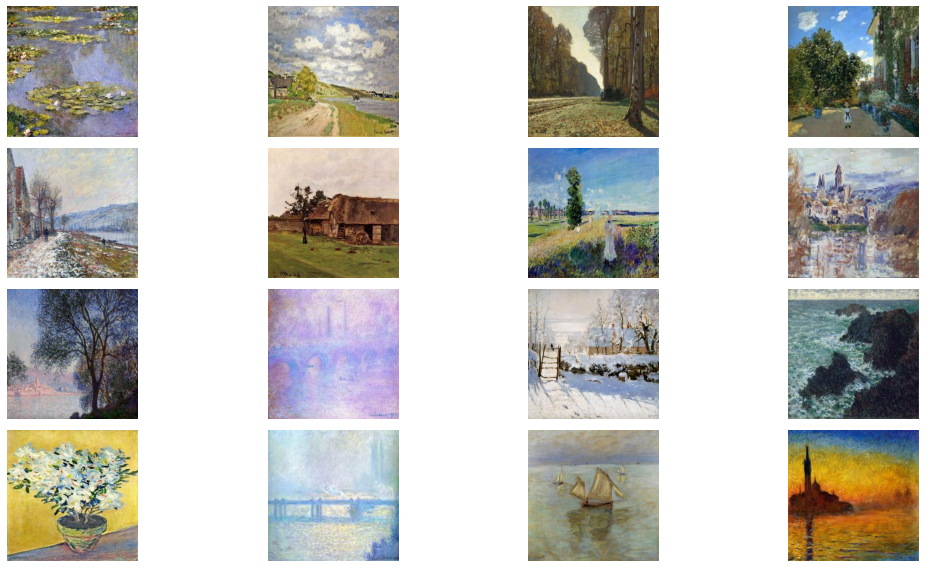

In [11]:
display_multiple_img(monet_images_path, 4, 4)

<div class="alert alert-block alert-info">  
<h3>Photo images</h3>
</div>

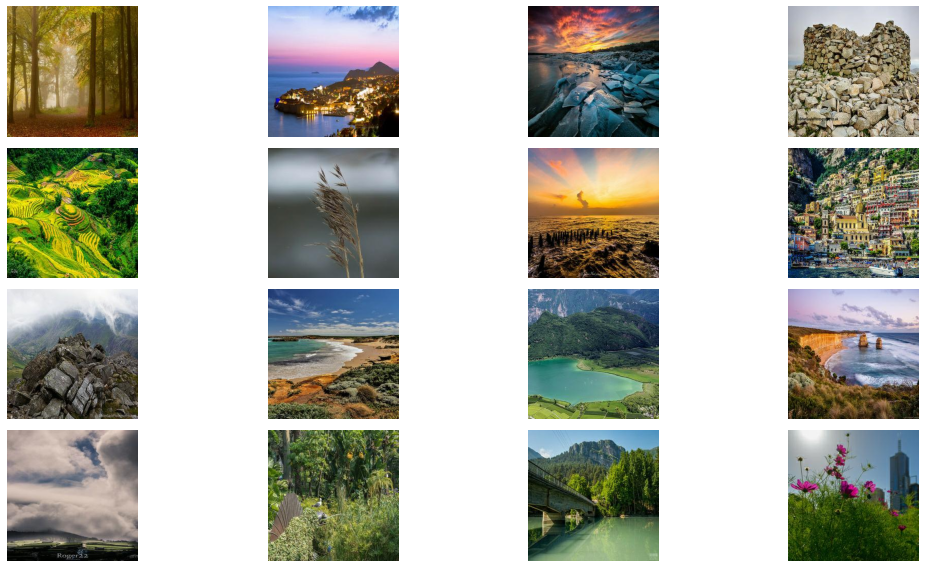

In [12]:
display_multiple_img(photo_images_path, 4, 4)

<div class="alert alert-block alert-info">  
<h3>Colour Histograms</h3>
</div>

In [13]:
def styling():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        plt.xticks([])
        plt.yticks([])

In [14]:
def hist(image_path):
    plt.figure(figsize=(16, 3))
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    styling()
    
    custom_colors = ["#ef233c", "#76da71", "#2667ff","#aea3b0"]
    labels = ['Red Channel', 'Green Channel', 'Blue Channel','Total']
    
    for i in range(1,4):
        plt.subplot(1, 5, i+1)
        plt.hist(img[:, :, i-1].reshape(-1),bins=64,color=custom_colors[i-1],alpha = 0.6)
        plt.xlabel(labels[i-1],fontsize=10)
        styling()
        
    plt.subplot(1, 5, 5)
    plt.hist(img.reshape(-1),bins=128,color=custom_colors[3],alpha = 0.6)
    plt.xlabel(labels[3],fontsize=10)
    styling()
    plt.show()

In [15]:
def display_hist(images_paths):
        for ind,image_path in enumerate(images_paths):
            if (ind<6):
                hist(image_path)

<h3> For Monet images </h3>

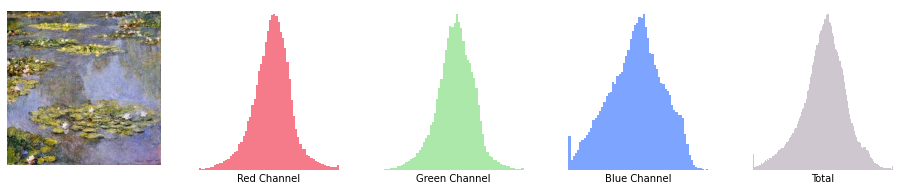

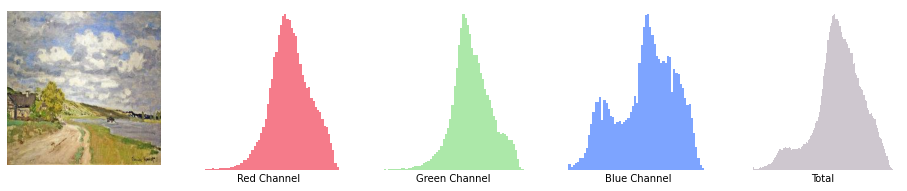

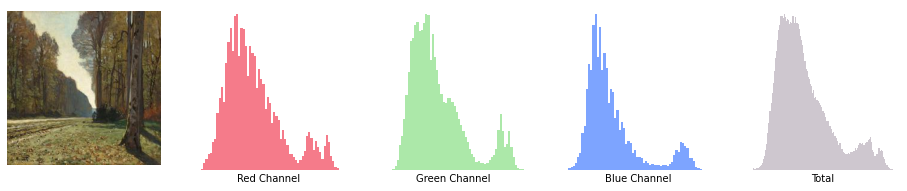

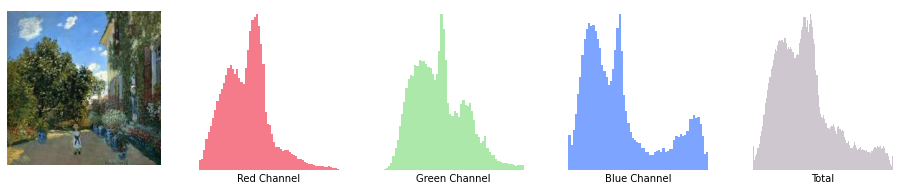

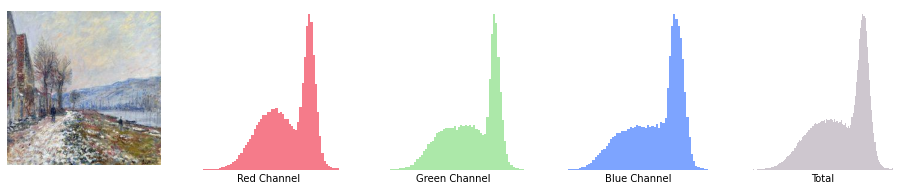

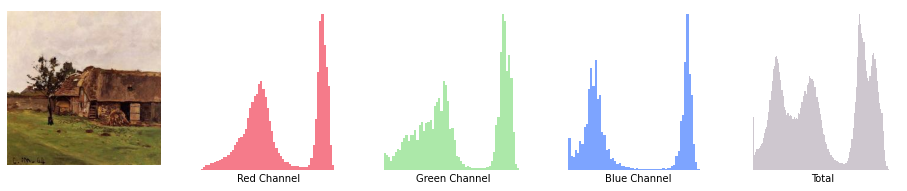

In [16]:
display_hist(monet_images_path)

<h3> For Photo images </h3>

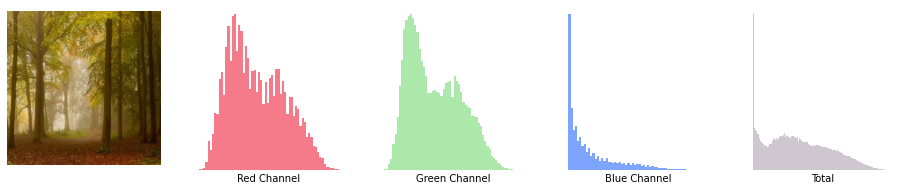

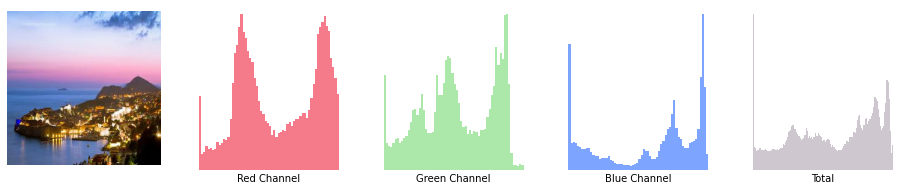

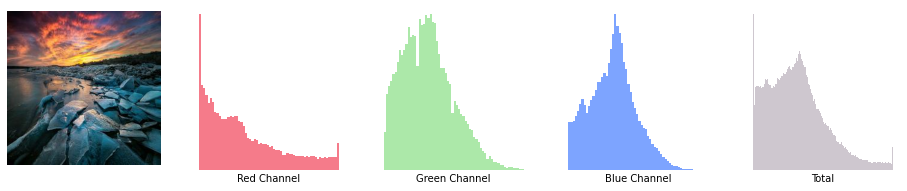

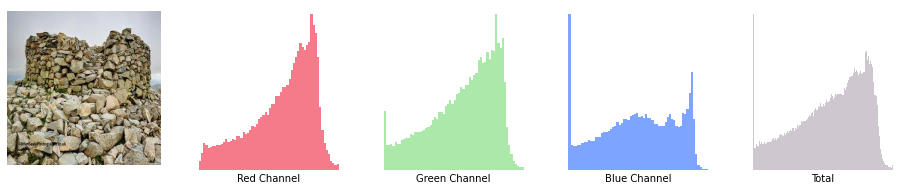

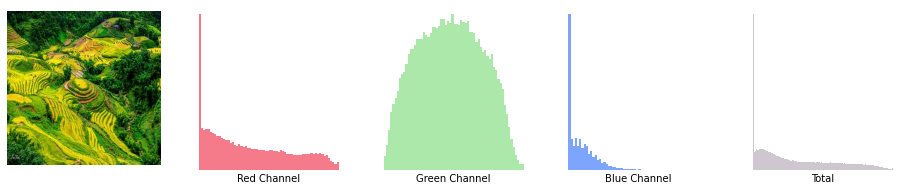

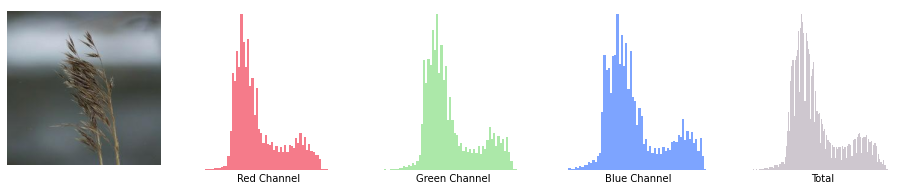

In [17]:
display_hist(photo_images_path)

<h3> Work in progress 🚧 </h3>